In [9]:
import matplotlib.pyplot as plt

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

### Exercise 1:

When I worked in Cambridge, Massachusetts, I usually took the subway to South Station and then a commuter train home to Needham. Because the subway was unpredictable, I left the office early enough that I could wait up to 15 minutes and still catch the commuter train.

When I got to the subway stop, there were usually about 10 people waiting on the platform. If there were fewer than that, I figured I just missed a train, so I expected to wait a little longer than usual. And if there there more than that, I expected another train soon.

But if there were a lot more than 10 passengers waiting, I inferred that something was wrong, and I expected a long wait. In that case, I might leave and take a taxi.

We can use Bayesian decision analysis to quantify the analysis I did intuitively. Given the number of passengers on the platform, how long should we expect to wait? And when should we give up and take a taxi?

### Assumptions We Can Make: 

- passenger arrivals are treated as a Poisson process (assume passengers are equally likely to arrive at any time) with a rate lambda (measured in passengers per minute)
    - assume lambda is constant
    
- revisiting Poisson assumptions in relation to this problem:
    - Events are independent -> pretty satisfied, each person is doing their own thing and not influencing the arrival of another
    - Average rate is constant -> we don't really know this, but are assuming it. Could likely determine from data. My guess is the average rate over a day varies, but maybe in this example holds up?
    - Two events can't occur at the same time -> we could have two people walk in at the same time, would this be an issue?
    
- arrival process for trains is not Poisson
    - I think it is not Poisson since arrivals aren't independent of one another, a late arrival could impact another train.
    - trains leave every 7-8 minutes from end of line, time ends up varying 3-12 at the station of interest
    
### Actual Equation We Are Solving:

P(Wait Time | Passengers) = P(Passengers | Wait Time) * P(Passengers) / P(Wait Time)

P(Passengers | Wait Time) = 

P(Passengers) = 

P(Time) = 

#### Building our prior: 

We are given sample gap times for the period of interest. This sample can be converted into a Pmf by using gaussian kernel density estimation.

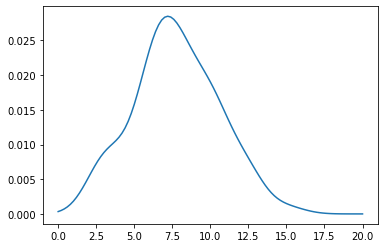

In [4]:
import numpy as np

from empiricaldist import Pmf
from scipy.stats import gaussian_kde

def kde_from_sample(sample, qs, **options):
    """Make a kernel density estimate from a sample
    sample: sequence of values
    qs: quantities where we should evaluate the KDE
    returns: normalized Pmf
    """
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs, **options)
    pmf.normalize()
    return pmf

# real MBTA data
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

# minutes
zs = np.array(observed_gap_times) / 60

# build quantities from 0 - 20
qs = np.linspace(0, 20, 101)

# build a pmf which will represent the prior of gap times
pmf_z = kde_from_sample(zs, qs)

# look at prior:
pmf_z.plot();


#### Likelihood: 

This gets tricky, so going to breakdown the logic proposed by the author. 

Our likelihood is going to be based on the gap times. And our author is more likely to arrive during a long gap than a short one....
- Assume I have 2 trains, one has a 1 min gap and one has a 99 min gap.
- If I randomly arrive at the station which gap am I more likely to hit? 
- Longer gaps are going to be more likely


This is an example of the **inspection paradox**, discussed here: https://towardsdatascience.com/the-inspection-paradox-is-everywhere-2ef1c2e9d709

And the friendship paradox: https://www.scientificamerican.com/article/why-youre-probably-less-popular/

#### Update:
- `pmf_z` is our prior, this is how the gap times tend to look
- Our posterior is just that prior multiplied by duration, so we'd expect a slight bump in our distribution for posterior.

#### What does our posterior really mean?

It is incorporating the fact (connected to inspection paradox) that an individual user of a train is more likely to randomly exist in a long gap time versus the mean gap time shared by the source data. The source data treats each gap as a random event that is uniformly probable, while this posterior is taking into consideration the increased likelihood of a large gap time. 

(7.772927524715933, 8.89677416786441)

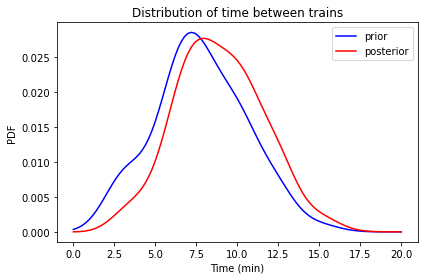

In [12]:
# likelihood is proportional to duration
likelihood = pmf_z.qs

# bayesian update 
posterior_z = pmf_z * pmf_z.qs
posterior_z.normalize()

# notice the slight shift
pmf_z.plot(label='prior', color='blue')
posterior_z.plot(label='posterior', color='red')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains');

# mean gap time shifts
pmf_z.mean(), posterior_z.mean()

#### Moving Into The Mixture: Finding Elapsed Time

- `z` above is time between trains. 
- `x` is time between arrival of train & passenger
- `y` is time between arrival of passenger and next train

Therefore: 
`z = x + y`

We have a distribution of `z`, but we want a distribution of `x`:

- Assume our gap is either 5 or 10 with equal probability:
    - Randomly arriving gives us a 1/3 chance at 5 min gap and 2/3 chance at 10 min gap
    - 5 min gap means `x` is uniform between 0 - 5 min
    - 10 min gap means `x` is uniform between 0 - 10 min
    - We then need to weight the above uniform distributions based on the likelihood of arriving (1/3 vs 2/3) in each
    
    
Mixture:
- We first build out a set of Pmfs representing the uniform distributions for each gap (`pmf_seq`)
- Considering the example above, we multiply the sequence by the posterior of z, which is going to help us account for the likelihood of any individual amount of time

In [15]:
def make_elapsed_dist(gap, qs):
    qs = qs[qs <= gap]
    n = len(qs)
    return Pmf(1/n, qs)

# As expected, if we have a 5 min gap we can't actually have 
# an elapsed wait time of > 5 min
make_elapsed_dist(5, np.asarray([0,1,2,3,4,5,6,7,8,9,10]))

,probs
0,0.166667
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667


In [18]:
# Take posterior possible gaps and use as array of time
qs = posterior_z.qs

# build a Pmf for each gap in qs
pmf_seq = [make_elapsed_dist(gap, qs) for gap in qs]

print(qs[10]) # using a gap of 2
print(pmf_seq[10]) # uniform distribution up to 2

2.0
0.0    0.090909
0.2    0.090909
0.4    0.090909
0.6    0.090909
0.8    0.090909
1.0    0.090909
1.2    0.090909
1.4    0.090909
1.6    0.090909
1.8    0.090909
2.0    0.090909
Name: , dtype: float64


In [21]:
import pandas as pd 
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [22]:
pmf_x = make_mixture(posterior_z, pmf_seq)

(8.89677416786441, 4.448387083932206)

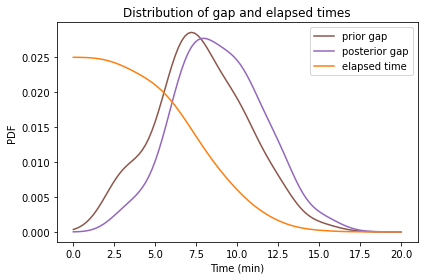

In [25]:
pmf_z.plot(label='prior gap', color='C5')
posterior_z.plot(label='posterior gap', color='C4')
pmf_x.plot(label='elapsed time', color='C1')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of gap and elapsed times');


posterior_z.mean(), pmf_x.mean()

#### Findings:

Our elapsed time estimate for a single gap of 5 min would be 2.5 (just the mean of uniform distribution, which is `(a + b) / 2` where `a = min` and `b = max`)

So it makes sense that the mean of our `elapsed time posterior` is `half of our gap posterior`

### Counting Passengers:

We now have an understanding of the distribution of elapsed time we might expect given the data. 

We now can make some assumptions:
- assume passengers are equally likely to arrive at any time
- assume they arrive at a rate of lambda, which is 2 passengers per minute

We can compute the likelihood of `n` passengers across each `x` (which is grabbed from the elapsed posterior)

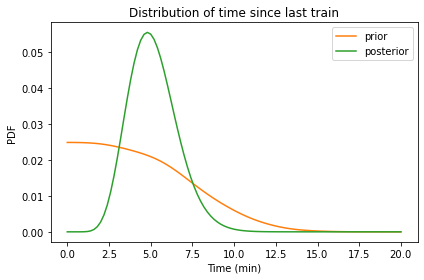

In [30]:
from scipy.stats import poisson

lam = 2
num_passengers = 10

# this function is going to multiply the lambda (rate by min)
# by the elapsed time (min), canceling out time and leaving with
# a timeless lambda 
# e.g. if elapsed time is 5 min, we use a lambda of 10 to see how likely
# it is to have num_passengers given this
likelihood = poisson(lam * pmf_x.qs).pmf(num_passengers)

# The update
posterior_x = pmf_x * likelihood
posterior_x.normalize()

# Plot
pmf_x.plot(label='prior', color='C1')
posterior_x.plot(label='posterior', color='C2')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time since last train')

In [31]:
pmf_x.mean(), posterior_x.mean()

(4.448387083932206, 5.1439350761797495)

#### Thoughts:

- The `lam * quantity` threw me off initially, but I think this stems from poisson pmf not having any "time" consideration. The way we handle varying amounts of time on a fixed amount of passengers is to modify the lambda parameter according to quantity.

Summarize: 

- First part: Gap Times
    - We started with a prior of gap time 
    - We then performed an update step by utilizing knowledge around the higher likelihood of larger gap times 
    - This gave us a distribution more accurately reflecting gap time from the perspective of a rider and not just (discrete) train schedules
    
- Second part: Elapsed Time
    - build a separate Pmf of elapsed time off of discrete gaps
    - used a mixture to blend that info with the gap time distribution, yielding us a distribution of elapsed time
    
 - Third Part: Elapsed Time Given A Passenger Count
    - Assume passengers arrive according to a poisson process
    - Utilize the quantities within distribution of elapsed time to generate a likelihood of seeing 10 passengers
    - Multiply the elapsed distribution by this likelihood 
    
    
At this point we can estimate how much time has passed since the last train based on the number of passengers we see (along with some data)

### Moving Into Wait Time: 

We can use: `z = x + y`

Since we know `x` and `z` we can solve for `y`, which represents remaining time of gap time or `wait time`

In [33]:
# we now have an estimate of wait time
posterior_y = Pmf.sub_dist(posterior_z, posterior_x)

# need to remove 0s
posterior_y = Pmf(posterior_y[posterior_y.qs >= 0])
posterior_y.normalize()

0.8900343090047254

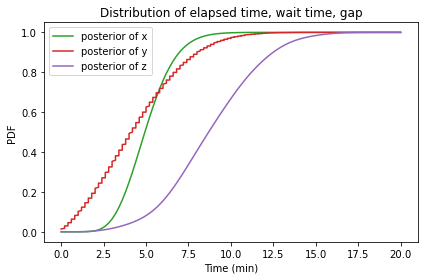

In [34]:
posterior_x.make_cdf().plot(label='posterior of x', color='C2')
posterior_y.make_cdf().plot(label='posterior of y', color='C3')
posterior_z.make_cdf().plot(label='posterior of z', color='C4')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of elapsed time, wait time, gap');